In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
import rasterio.mask
import matplotlib.pyplot as plt

Index(['OBJECTID', 'TAZID', 'AREA', 'X', 'Y', 'ZONE', 'LENG_ROAD',
       'SHAPE_Leng', 'SHAPE_Area', 'geometry'],
      dtype='object')
(491, 10)


<Axes: >

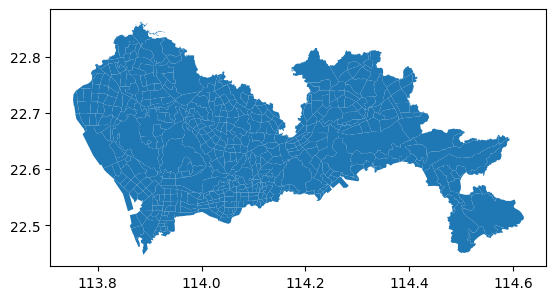

In [2]:
shenzhen_zone = gpd.read_file("/gpfsnyu/home/yw9871/New data/Original_data/Shenzhen/Shenzhen.shp") 
shenzhen_zone['TAZID'] = shenzhen_zone['TAZID'].astype(int)
shenzhen_zone = shenzhen_zone.set_crs(epsg=3857)
shenzhen_zone = shenzhen_zone.to_crs(epsg=4326)
print(shenzhen_zone.columns)
print(shenzhen_zone.shape)
shenzhen_zone.plot()

Index(['ID', 'AREA', 'ID1', 'AREA1', 'NAME', 'DISTRICT', 'DISTRICT_I',
       'BLOCK_ID', 'geometry'],
      dtype='object')
(74, 9)


<Axes: >

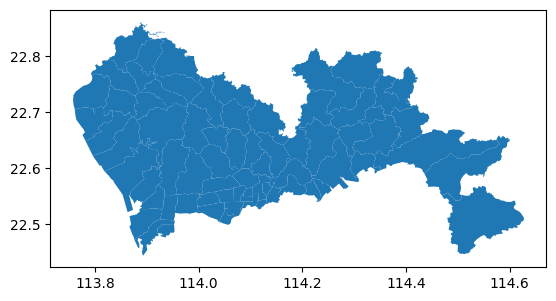

In [3]:
shenzhen_district = gpd.read_file("/gpfsnyu/home/yw9871/New data/Original_data/Shenzhen/深圳街道.shp",encoding='utf-8')
shenzhen_district = shenzhen_district.to_crs(epsg=4326)
print(shenzhen_district.columns)
print(shenzhen_district.shape)
shenzhen_district.plot()

In [4]:
zone_information = pd.read_csv("/gpfsnyu/home/yw9871/New data/Original_data/zone-information.csv")
zone_information.head(2)

,Unnamed: 0,TAZID,longitude,latitude,charge_count,area,perimeter,name,district
0,0,1066,113.910301,22.521287,40,1577892.982,5119.3013,南山,南山区
1,1,1068,113.918680,22.517837,271,1405268.834,5460.2638,南山,南山区


In [5]:
zone348 = shenzhen_zone[shenzhen_zone['TAZID']==348].to_crs(epsg=4326)
zone348_point = zone348.geometry.centroid
zone_information.loc[zone_information['TAZID'] == 348, 'longitude'] = zone348_point.x.iloc[0]
zone_information.loc[zone_information['TAZID'] == 348, 'latitude'] = zone348_point.y.iloc[0]
zone_information[zone_information['TAZID']==348]

/tmp/ipykernel_285802/3269158614.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zone348_point = zone348.geometry.centroid


,Unnamed: 0,TAZID,longitude,latitude,charge_count,area,perimeter,name,district
139,139,348,113.967665,22.520288,132,3082857.139,11446.4803,沙河,南山区


In [6]:
zone = pd.merge(shenzhen_zone, zone_information, how='right', on='TAZID')
zone = zone[['TAZID','longitude','latitude']]
zone = gpd.GeoDataFrame(zone, geometry=gpd.points_from_xy(zone['longitude'], zone['latitude']), crs='EPSG:4326')
print(zone.shape)
zone.head(2)

(275, 4)


,TAZID,longitude,latitude,geometry
0,1066,113.910301,22.521287,POINT (113.9103 22.52129)
1,1068,113.918680,22.517837,POINT (113.91868 22.51784)


In [7]:
zone_district = gpd.sjoin(zone, shenzhen_district, how='left', predicate='within')
print(zone_district.columns)
print(zone_district.shape)
print(f"未匹配的小区域数量：{len(zone_district[zone_district['ID'].isna()])}")
zone_district.head(2)

Index(['TAZID', 'longitude', 'latitude', 'geometry', 'index_right', 'ID',
       'AREA', 'ID1', 'AREA1', 'NAME', 'DISTRICT', 'DISTRICT_I', 'BLOCK_ID'],
      dtype='object')
(275, 13)
未匹配的小区域数量：0


,TAZID,longitude,latitude,geometry,index_right,ID,AREA,ID1,AREA1,NAME,DISTRICT,DISTRICT_I,BLOCK_ID
0,1066,113.910301,22.521287,POINT (113.9103 22.52129),52,95,23.309164,2,23.309266,南山,南山区,3,27
1,1068,113.918680,22.517837,POINT (113.91868 22.51784),52,95,23.309164,2,23.309266,南山,南山区,3,27


In [8]:
zone_merged = pd.merge(zone_information, zone_district, how='left', on='TAZID')
zone_merged = zone_merged[['TAZID', 'longitude_x', 'latitude_x', 'charge_count', 'area', 'perimeter', 'NAME', 'DISTRICT']]
zone_merged.columns = ['TAZID', 'longitude', 'latitude', 'charge_count', 'area', 'perimeter', 'name', 'district']
print(zone_merged.columns)
zone_merged.head(2)

Index(['TAZID', 'longitude', 'latitude', 'charge_count', 'area', 'perimeter',
       'name', 'district'],
      dtype='object')


,TAZID,longitude,latitude,charge_count,area,perimeter,name,district
0,1066,113.910301,22.521287,40,1577892.982,5119.3013,南山,南山区
1,1068,113.918680,22.517837,271,1405268.834,5460.2638,南山,南山区


In [9]:
zone_merged.to_csv("/gpfsnyu/home/yw9871/New data/Original_data/zone-information.csv",index=None)